In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 

/home/sklab2/anaconda3/envs/vessel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2


In [2]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet
from helper import *
import loss

# Config

In [3]:
ckpt_path = './ckpt'
exp_name = 'PFNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 200,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 5e-4, 
    'lr_decay': 0.9,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [4]:
# loss function
structure_loss = loss.structure_loss().to(device)
bce_loss = nn.BCEWithLogitsLoss().to(device)
iou_loss = loss.IOU().to(device)

In [5]:
def bce_iou_loss(pred, target):
    bce_out = bce_loss(pred, target)
    iou_out = iou_loss(pred, target)
    loss = bce_out + iou_out
    return loss

# Net

In [6]:
net = PFNet(backbone_path)

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau



if args['optimizer'] == 'SGD':
    print('SGD opt')
    optimizer = torch.optim.SGD([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
        'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
        'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ], momentum=args['momentum'])

else:
    print('Adam opt')
    optimizer = torch.optim.Adam([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
            'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
            'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ])

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, \
#                                 threshold=0.05, threshold_mode='rel', cooldown=5, min_lr = 1e-4)

scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=50, cycle_mult=1.0, max_lr=0.005, min_lr=5e-4, warmup_steps=5, gamma=0.5)

Adam opt


## making data index list

In [8]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1691

In [9]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,  50, 53, 54, 55 
train_indexs = []
test_indexs = []
for idx, data in enumerate(mask_idxs):
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [10]:
len(train_indexs) , len(test_indexs)

(1319, 355)

# Dataloader

In [12]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        try:
            s_1 = self.index[idx][0]
            s_1_2 = self.index[idx+1][0]
            s_2 = self.index[idx][1]
            s_2_2 = self.index[idx+1][1]
        except:
            s_1 = self.index[idx][0]
            s_1_2 = self.index[idx][0]
            s_2 = self.index[idx][1]
            s_2_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').resize((416, 416),Image.Resampling.BILINEAR)
        # image_2 = Image.open(PATH+'origin/' + s_1_2+'_L_'+s_2_2+'.jpg').resize((416, 416),Image.Resampling.BILINEAR)
        #'10_L_112_L.png', 
        mask = Image.open(PATH+'masked/' +  s_1+'_'+s_2+'.png').resize((416, 416),Image.Resampling.BILINEAR)
        mask2 = Image.open(PATH+'masked/' +  s_1_2+'_'+s_2_2+'.png').resize((416, 416),Image.Resampling.BILINEAR)
        
        image= np.array(image, dtype=np.uint8) #RGB
        mask, mask2 = np.array(mask, dtype=np.uint8), np.array(mask2, dtype=np.uint8)   # HWC
        mask_img = mask / 255
        mask_img2 = mask2/255
        
        # print(mask.shape)

        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255]) 

        mask_hsv = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)
        mask2_hsv = cv2.cvtColor(mask2, cv2.COLOR_RGB2HSV)

        mask = cv2.inRange(mask_hsv, lower_red, upper_red)
        mask2 = cv2.inRange(mask2_hsv, lower_red, upper_red)
        mask_o = np.clip(mask, 0, 255) / 255
        or_mask = cv2.bitwise_or(mask, mask2)
        # or_mask = cv2.bitwise_not(mask, mask2)
        # or_mask = 255 - or_mask
        or_mask = np.clip(or_mask, 0, 255) / 255

        # or_mask = or_mask[np.where(or_mask >= 0.4)]
        
        # or_mask = cv2.resize(or_mask, (416, 416), interpolation=cv2.INTER_BILINEAR)
        masks = [or_mask, mask_img, mask_o]  # target, mask img, original

        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        if self.transforms:
            transformed = self.transforms(image=image, masks=masks)
            image, masks = transformed['image'], transformed['masks']
        # urls.append(s_1+'_'+s_2)
        assert sum(masks[0]==0).sum() + sum(masks[0]==1).sum() == 416*416   # mask가 0 또는 1이 아닐경우 스탑
        

                    
        return image, masks, s_1+'_'+s_2

In [13]:
import albumentations.pytorch as AP

prob = 0.3

train_transform = A.Compose([
    A.RandomRotate90(p=prob),
    A.HorizontalFlip(p=prob),
    # A.OneOf([
    #     A.OpticalDistortion(p=1),
    #     A.GridDistortion(p=1),
    #     A.ElasticTransform(p=1),
    #     ], p = prob),
    # A.OneOf([
    #     A.CLAHE(clip_limit=2, p=1),
    #     A.RandomBrightnessContrast(p=1),
    #     ], p = prob),
    # # A.Normalize(mean=(126.8661, 126.8530, 127.0134), std = (32.9434, 33.0122, 32.9186)),
    AP.ToTensorV2(always_apply=True)
])

test_transform = A.Compose([
    AP.ToTensorV2(always_apply=True)
])

# tensor([127.5388, 127.5482, 127.6733])
# tensor([57.4250, 57.6999, 57.5387])
train_dataset = VesselDataset(index=train_indexs, transforms=train_transform)
test_dataset = VesselDataset(index=test_indexs, transforms=test_transform)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

image, masks, _= next(iter(train_loader))
print(image.shape, masks[0].shape, masks[1].shape, masks[2].shape)


# mask[0]: inrange, or, transform
# mask[1]: original mask img
# mask[2]: inrange, transform

torch.Size([32, 3, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 416, 416, 3]) torch.Size([32, 416, 416])


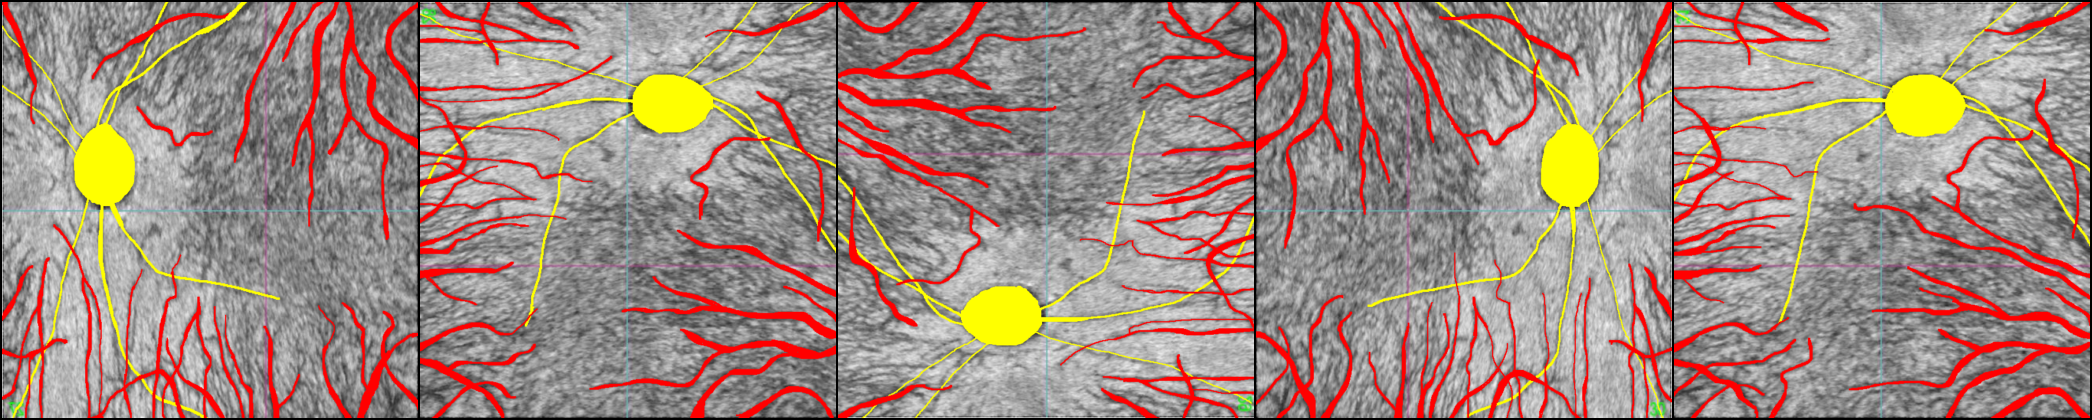

In [14]:
TF.to_pil_image(torchvision.utils.make_grid(masks[1][:5].permute(0, 3, 1, 2))) # original mask img

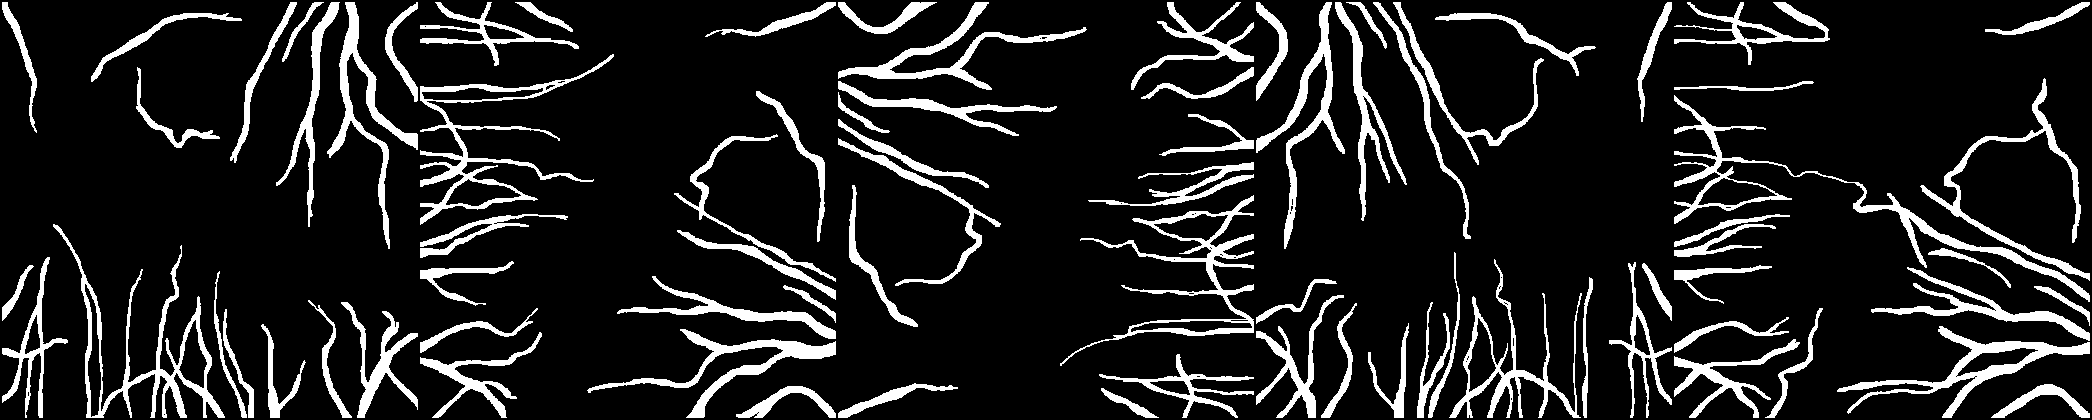

In [15]:
TF.to_pil_image(torchvision.utils.make_grid(masks[0][:5].unsqueeze(1).expand(5, 3, 416, 416)))  # : inrange, or, transform

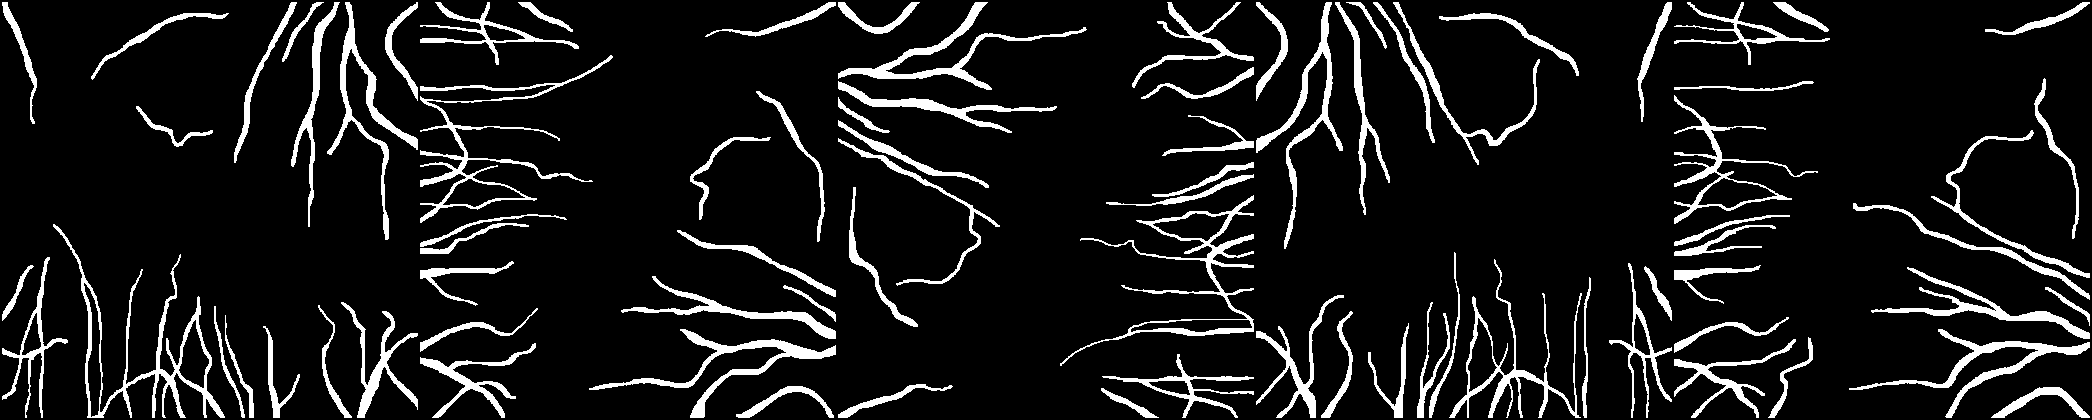

In [16]:
TF.to_pil_image(torchvision.utils.make_grid(masks[2][:5].unsqueeze(1).expand(5, 3, 416, 416))) # inrange, transform

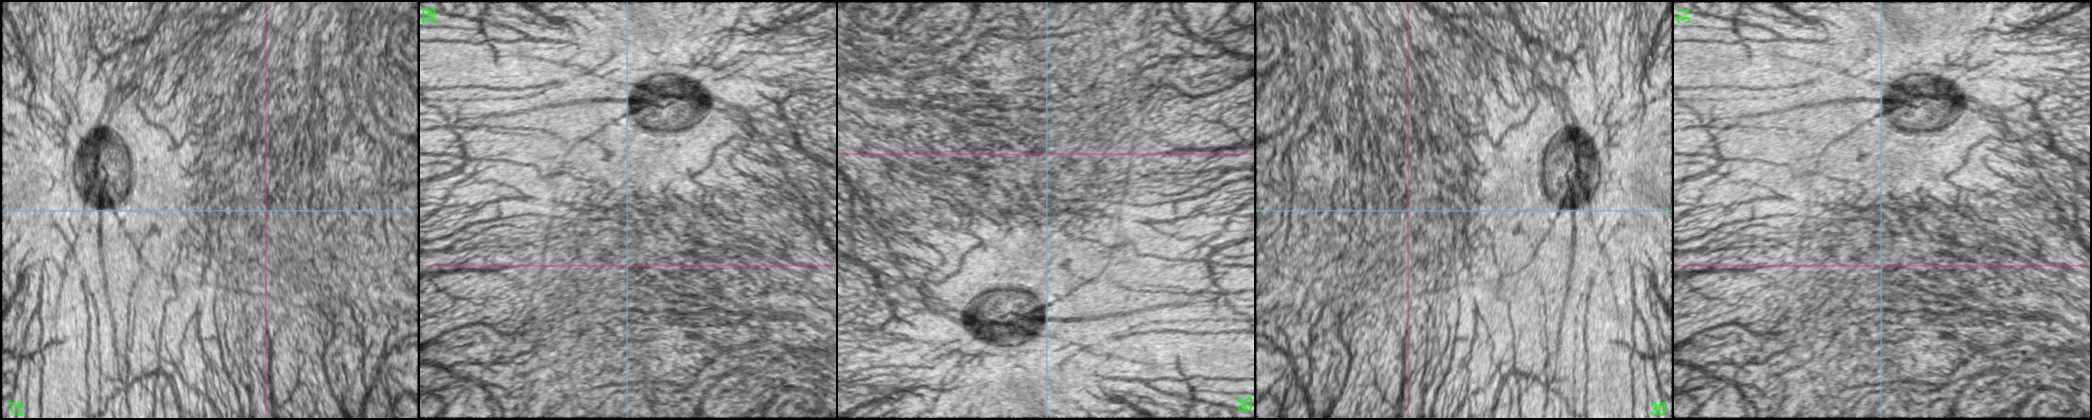

In [17]:
TF.to_pil_image(torchvision.utils.make_grid(image[:5]))

In [18]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, score_f1, score_recall, score_precision, score_acc)
    return score_jaccard, score_f1, score_recall, score_precision, score_acc

# Train

In [18]:
from tensorboardX import SummaryWriter
import datetime 

exp = 'union+coslr'

num_epochs = args['epoch_num']
resume_epochs = args['last_epoch']
load_from = '../model/vessel_PFNet_base_b32_e500_220921_00:30.pt'


batch_size = args['train_batch_size']
scaler = torch.cuda.amp.GradScaler()
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_PFNet_{exp}_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'

if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    net = nn.DataParallel(net)

# net.float()
net = net.to(device)
train_loss_list = []
test_acc_list = []
test_recall_list = []
test_f1_list = []
print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
if resume_epochs != 0:
    print(f'Resuming from epoch {resume_epochs}')
    net.load_state_dict(torch.load(load_from))
if args['amp'] == True:
    print("Using mixed precision.")

# print(data.shape, aug_masks[0].shape, aug_masks[1].shape, aft_mask.shape)
curr_iter = 1

for epoch in range(args['last_epoch'], args['last_epoch'] + args['epoch_num']):
    
    net.train()

    loss_1_running, loss_2_running, loss_3_running, loss_4_running, loss_running = 0, 0, 0, 0, 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):
        if args['poly_train']:
            base_lr = args['lr'] * (1 - float(curr_iter) / float(num_epochs)) ** args['lr_decay']
            optimizer.param_groups[0]['lr'] = 2 * base_lr
            optimizer.param_groups[1]['lr'] = 1 * base_lr

        image, masks,  _ = batch
        # mask[0]: inrange, or, transform
        # mask[1]: original mask img
        # mask[2]: inrange, transform

        labels = masks[0]
        labels = labels.unsqueeze(1)
        image, labels = image.float().to(device), labels.float().to(device)
        optimizer.zero_grad()

        # mixed precision
        if args['amp'] == True:
            with torch.cuda.amp.autocast():

                predict_1, predict_2, predict_3, predict_4 = net(image)
                
                loss_1 = bce_iou_loss(predict_1, labels)
                loss_2 = structure_loss(predict_2, labels)
                loss_3 = structure_loss(predict_3, labels)
                loss_4 = structure_loss(predict_4, labels)
                loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4

            scaler.scale(loss).backward()
            # nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
            scaler.step(optimizer)
            scaler.update()

        else:
            predict_1, predict_2, predict_3, predict_4 = net(image)

            loss_1 = bce_iou_loss(predict_1, labels)
            loss_2 = structure_loss(predict_2, labels)
            loss_3 = structure_loss(predict_3, labels)
            loss_4 = structure_loss(predict_4, labels)
            loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4
            
            loss.backward()
            # nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
            optimizer.step()
        
        loss_1_running += loss_1.item()
        loss_2_running += loss_2.item()
        loss_3_running += loss_3.item()
        loss_4_running += loss_4.item()
        loss_running += loss.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch,
            'Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(loss_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer.param_groups[0]["lr"])
        })

        curr_iter += 1

    epoch_loss = loss_running / len(train_loader)
    epoch_loss_1 = loss_1_running / len(train_loader)
    epoch_loss_2 = loss_2_running / len(train_loader)
    epoch_loss_3 = loss_3_running / len(train_loader)
    epoch_loss_4 = loss_4_running / len(train_loader)

    scheduler.step()

    writer.add_scalar('loss/Train', epoch_loss, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    train_loss_list.append(epoch_loss)

## EVAL
    if epoch % 5 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        images=[]
        preds=[]
        labels=[]
        label_os = []
        urls_list = []
        net.eval()
        # tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            for idx, dd in enumerate(test_loader):

                image, masks, urls = dd 
                # mask[0]: inrange, or, transform
                # mask[1]: original mask img
                # mask[2]: inrange, transform
                
                image = image.float().to(device)
                label = masks[2].float()
                label_o = masks[1].float()
                _, _, _, pred = net(image)    

                images.append(image.cpu().detach().numpy())
                labels.append(label.numpy())
                label_os.append(label_o)
                preds.append(pred.cpu().detach().numpy())
                urls_list.append(urls)

            images= np.array(images).squeeze(1)
            preds = np.array(preds).squeeze(1)
            labels = np.array(labels)
            label_os = np.array(label_os)
            preds = np.where(preds > 0.5 , 1 , 0)
            labels = np.where(labels > 0.5 , 1 , 0)
            
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            test_f1_list.append(score_f1)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_f1_list) == test_f1_list[-1] or np.max(test_recall_list) == test_recall_list[-1]:
                torch.save(net.state_dict(), save_path)
                print("Model Saved")

            randnum = np.random.randint(0, 171)
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)  
            plt.imshow(label_os[randnum][0])
            plt.subplot(1, 3, 2)  
            plt.imshow(labels[randnum][0])
            plt.subplot(1, 3, 3)
            plt.imshow(preds[randnum][0])
            plt.tight_layout()
            plt.show()

Using 2 GPUs.
union+coslr_b32_e200_js_220923_19:01
../model/vessel_PFNet_union+coslr_b32_e200_220923_19:01.pt
Training 200 epochs.


 98%|█████████▊| 41/42 [02:31<00:03,  3.69s/it, Epoch=0, Loss=7.113363, Mean Loss=8.777407, lr=0.000500] 


IndexError: list index out of range

# evaluation

In [21]:
print("Testing...")
net = PFNet(backbone_path)
load_from = '/home/sklab2/workspace/code_only/model/vessel_PFNet_union+coslr_b32_e200_220923_19:10.pt'
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    net = nn.DataParallel(net)
net.load_state_dict(torch.load(load_from))
net.to(device)

# mask[0]: inrange, or, transform
# mask[1]: original mask img
# mask[2]: inrange, transform

images=[]
preds=[]
labels=[]
label_os = []
urls_list = []
net.eval()
# tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    for idx, dd in enumerate(tqdm(test_loader)):

        image, masks,  urls = dd 
        
        image = image.float().to(device)
        label = masks[2].float()
        label_o = masks[1].float()
        _, _, _, pred = net(image)    

        images.append(image.cpu().detach().numpy())
        labels.append(label.numpy())
        label_os.append(label_o)
        preds.append(pred.cpu().detach().numpy())
        urls_list.append(urls)

    images= np.array(images).squeeze(1)
    preds = np.array(preds).squeeze(1)
    labels = np.array(labels)
    label_os = np.array(label_os)
    preds = np.where(preds > 0.5 , 1 , 0)
    labels = np.where(labels > 0.5 , 1 , 0)
    
    score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)

Testing...
From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!
Using 2 GPUs.


100%|██████████| 355/355 [01:15<00:00,  4.70it/s]


jaccard, f1, recall, precision, acc
0.3974783160099247 0.5688507813771356 0.7083070384741842 0.4752753680135111 0.9024067923629052


NameError: name 'test_acc_list' is not defined

In [ ]:
# randnum = np.random.randint(0, len(test_dataset)-10)
randnum=211

fig, axes = plt.subplots(10, 3, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax , mask_ax ) in zip(range(randnum, randnum+10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = images[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target = preds[idx].transpose(1, 2, 0) 
    img_mask = labels[idx].transpose(1, 2, 0)  
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax.imshow(img_target )
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax.set_title(f' Predicted : {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()